In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# Regression Network

In [52]:
class LocalizationCNN(nn.Module):
    def __init__(self):
        super(LocalizationCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64)
        )
        
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 2 * 2, 128),  # Adjust the size based on the output of the last conv layer
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 6)  # Output layer for x, y coordinates and velocities
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

# Load and prepare the dataset
def load_data(X, Y, training_size=0.8):
    dataset = TensorDataset(X, Y)

    # Splitting dataset into training and validation
    train_size = int(training_size * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    return train_dataset, val_dataset

def train_model(model, device, train_loader, val_loader, optimizer, loss_function, epochs):
    model.train()
    training_losses = []
    validate_losses = []
    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.size(0)
        training_avg_loss = total_loss / len(train_loader.dataset)
        training_losses.append(training_avg_loss) # average loss for each epoch
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, target)
            total_loss += loss.item() * data.size(0)
        validate_avg_loss = total_loss / len(val_loader.dataset)
        validate_losses.append(validate_avg_loss)
        print(f'Epoch {epoch+1}, Training Loss: {training_avg_loss:.7f}, Validation Loss: {validate_avg_loss:.7f}')
    return training_losses, validate_losses

def validate_model(model, device, val_loader, loss_function):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output, target)
            total_loss += loss.item() * data.size(0)
    avg_loss = total_loss / len(val_loader.dataset)
    print(f'Validation Loss: {avg_loss:.4f}')
    return avg_loss

def plot_learning_curves(training_losses, validation_losses, start, title):
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses[start:], label='Training Loss')
    plt.plot(validation_losses[start:], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training

In [49]:
# load training data
X = torch.load('training_images.pt')
# Y = torch.load('position_labels.pt')
Y = torch.load('velocity_labels.pt')
print(X.shape, Y.shape)

torch.Size([1200, 15, 32, 32]) torch.Size([1200, 6])


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Load data
train_dataset, val_dataset = load_data(X, Y)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # data set sorted into batches of 64 and shuffled
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [53]:
# Initialize the model and other components
model = LocalizationCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

# Training and Validation
training_losses, validate_losses = train_model(model, device, train_loader, val_loader, optimizer, loss_function, epochs=300)

Epoch 1, Training Loss: 0.0195622, Validation Loss: 0.0793210
Epoch 2, Training Loss: 0.0008774, Validation Loss: 0.0041977
Epoch 3, Training Loss: 0.0006020, Validation Loss: 0.0028885
Epoch 4, Training Loss: 0.0004689, Validation Loss: 0.0023300
Epoch 5, Training Loss: 0.0004318, Validation Loss: 0.0021331
Epoch 6, Training Loss: 0.0003632, Validation Loss: 0.0017732
Epoch 7, Training Loss: 0.0002885, Validation Loss: 0.0014396
Epoch 8, Training Loss: 0.0002685, Validation Loss: 0.0013362
Epoch 9, Training Loss: 0.0002598, Validation Loss: 0.0012923
Epoch 10, Training Loss: 0.0002419, Validation Loss: 0.0012106
Epoch 11, Training Loss: 0.0002119, Validation Loss: 0.0010328
Epoch 12, Training Loss: 0.0001779, Validation Loss: 0.0008767
Epoch 13, Training Loss: 0.0001728, Validation Loss: 0.0008521
Epoch 14, Training Loss: 0.0001566, Validation Loss: 0.0007790
Epoch 15, Training Loss: 0.0001505, Validation Loss: 0.0007483
Epoch 16, Training Loss: 0.0001419, Validation Loss: 0.0007055
E

In [47]:
Y[:10]

tensor([[ 0.0150, -0.0055,  0.0000,  0.0300, -0.0110,  0.0000],
        [ 0.0132, -0.0090,  0.0000,  0.0264, -0.0180,  0.0000],
        [ 0.0105, -0.0120,  0.0000,  0.0211, -0.0240,  0.0000],
        [ 0.0072, -0.0142,  0.0000,  0.0145, -0.0285,  0.0000],
        [ 0.0035, -0.0156,  0.0000,  0.0070, -0.0312,  0.0000],
        [-0.0005, -0.0160,  0.0000, -0.0009, -0.0319,  0.0000],
        [-0.0044, -0.0154,  0.0000, -0.0088, -0.0307,  0.0000],
        [-0.0081, -0.0138,  0.0000, -0.0161, -0.0276,  0.0000],
        [-0.0112, -0.0114,  0.0000, -0.0224, -0.0227,  0.0000],
        [-0.0137, -0.0082,  0.0000, -0.0274, -0.0165,  0.0000]])

In [45]:
model(X[:10])

tensor([[-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20],
        [-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20],
        [-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20],
        [-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20],
        [-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20],
        [-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20],
        [-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20],
        [-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20],
        [-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20],
        [-1.5563e-03, -2.7508e-03, -1.7327e-28, -3.0895e-03, -5.5822e-03,
         -5.4102e-20]], grad_fn=<AddmmBackward0>)

In [6]:
# Save the trained model
torch.save(model.state_dict(), 'localization_cnn.pt')

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'velocity_cnn.pt')

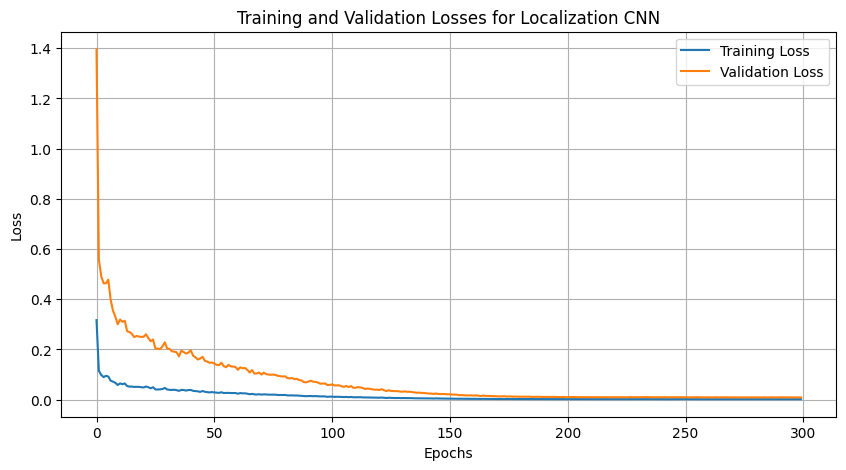

In [41]:
# Plot the learning curves
plot_learning_curves(training_losses, validate_losses, 0, 'Training and Validation Losses for Localization CNN')

In [ ]:
# Plot the learning curves
plot_learning_curves(training_losses, validate_losses, 0, 'Training and Validation Losses for Velocity CNN')